### Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import dlc_bci as bci
from dlc_practical_prologue import *

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from scipy.signal import hilbert, chirp
from scipy import signal

### Plot functions

In [2]:
def plot_channel(tr_input, tr_target, ch = 2, num = 4):

    for i in range(num):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

        sample = tr_input[2*i,ch,:].numpy()  
    #     sample = tr_input[0,2*i,:].numpy()
        ax1.plot(sample)
        ax1.set_title(tr_target[2*i][0])

        sample = tr_input[2*i+1,ch,:].numpy()
    #     sample = tr_input[0,2*i+1,:].numpy()
        ax2.plot(sample)
        ax2.set_title(tr_target[2*i+1][0])
        plt.show()

In [3]:
def plot_fft(tr_input, tr_target, ch = 2, num = 4, target = 1):
    
    sample = tr_input[:num,ch,:].numpy()
    sample_target = tr_target[:num,0]
    
    for t, channel in zip(sample_target, sample):
        if int(t == target):
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
            sample_fft = np.fft.fft(channel)
            ax1.plot(channel)
            ax2.plot(abs(np.fft.fft(channel)))

            plt.show()

In [4]:
def plot_spectrogram(tr_input, tr_target, ch = 2, num = 4, target = 1, freq = 100, nseg = 10):
    
    sample = tr_input[:num,ch,:].numpy()
    sample_target = tr_target[:num,0]
    
    for t, channel in zip(sample_target, sample):
        if int(t == target):
            f, t, Sxx = signal.spectrogram(channel, freq, nperseg=nseg)
            plt.pcolormesh(t, f, Sxx)
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time [sec]')
            plt.show()


In [88]:
# f, t, Sxx = signal.spectrogram(tr_input[0,0,:], 100, nperseg=10)
# plt.pcolormesh(t, f, Sxx)
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()
# plot_spectrogram(tr_input, tr_target, ch=2, num=30, target=1, freq=100, nseg=10)

In [5]:
def plot_pair(before, after, ch = 2, num = 4):
    sample_before = before[:num,ch,:].numpy()
    sample_after = after[:num,ch,:].numpy()
    
    for channel1, channel2 in zip(sample_before, sample_after):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6), sharey=True)
        ax1.plot(channel1)
        ax2.plot(channel2)
        
        plt.show()

### Load dataset

In [6]:
# tr_input_org, tr_target = bci.load("bci", train=True, one_khz=True)
tr_input_org, tr_target = bci.load("bci", train=True, one_khz=False)
# te_input_org, te_target = bci.load("bci", train=False, one_khz=True)
te_input_org, te_target = bci.load("bci", train=False, one_khz=False)

tr_target = convert_to_one_hot_labels(tr_input_org, tr_target)
te_target = convert_to_one_hot_labels(te_input_org, te_target)

tr_target = Variable(tr_target)
te_target = Variable(te_target)

### Preprocessing - moving average / downsampling / DC blocker / DFT

In [7]:
def conv_lowpass(signal, N):    
    return np.convolve(signal, np.ones((N,))/N, mode='valid')

def lowpass_filtering(signal, N):
    sample = conv_lowpass(signal[0,0,:].numpy(), N)
    
    signal_filtered = torch.zeros([signal.shape[0], signal.shape[1], sample.shape[0]])

    for idx1, data in enumerate(signal):
        for idx2, channel in enumerate(data):
            signal_filtered[idx1, idx2, :] = torch.from_numpy(conv_lowpass(channel.numpy(), N))
    
    return signal_filtered    

def downsampling_filtering(signal, Nd):
    sample = signal[0,0,:].numpy()[::Nd]
    
    signal_filtered = torch.zeros([signal.shape[0], signal.shape[1], sample.shape[0]])

    for idx1, data in enumerate(signal):
        for idx2, channel in enumerate(data):
#             signal_filtered[idx1, idx2, :] = torch.from_numpy(channel.numpy()[::Nd])
            signal_filtered[idx1, idx2, :] = channel[::Nd]
    
    return signal_filtered

def dc_blocker(signal, alpha = 0.9):
    y = np.zeros(signal.shape[0]+1)
    y[0] = signal[0]
    
    for i in range(1, len(signal)):
        y[i] = alpha * y[i-1] + signal[i] - signal[i-1]
        i+=1
    
    return y

def dc_blocker_filtering(signal, alpha_ = 0.9):
    sample = dc_blocker(signal[0,0,:].numpy(), alpha=alpha_)
    signal_filtered = torch.zeros([signal.shape[0], signal.shape[1], sample.shape[0]])
    
    for idx1, data in enumerate(signal):
        for idx2, channel in enumerate(data):
            signal_filtered[idx1, idx2, :] = torch.from_numpy(dc_blocker(channel.numpy(), alpha=alpha_))
    
    return signal_filtered


def fft_data(signal, size, with_phase):
    sample_fft = np.fft.fft(signal)
    sample_angle = np.angle(sample_fft)
    
    if with_phase:
        return np.append(abs(sample_fft)[0:size],sample_angle[0:size])
    else:
        return abs(sample_fft)[0:size]

def fft_input_generation(signal, size, with_phase):
    sample = fft_data(signal[0,0,:].numpy(), size, with_phase)
    signal_filtered = torch.zeros([signal.shape[0], signal.shape[1], sample.shape[0]])
    
    for idx1, data in enumerate(signal):
        for idx2, channel in enumerate(data):
            signal_filtered[idx1, idx2, :] = torch.from_numpy(fft_data(channel.numpy(), size, with_phase))
    return signal_filtered

def spectrogram_data(signal_, freq, npers):
    f, t, Sxx = signal.spectrogram(signal_, freq, nperseg=npers)
    return Sxx.ravel()

def spectrogram_input_generation(signal_, freq = 100, npers = 10):
    sample = spectrogram_data(signal_[0,0,:], freq, npers)
    signal_filtered = torch.zeros([signal_.shape[0], signal_.shape[1], sample.shape[0]])

    for idx1, data in enumerate(signal_):
        for idx2, channel in enumerate(data):
            signal_filtered[idx1, idx2, :] = torch.from_numpy(spectrogram_data(channel, freq, npers))
    return signal_filtered
    
def peak_detector(signal, N):
    length = signal.shape[0]
    result = np.zeros(length - N)
    for i in range(length - N):
        result[i] = np.max(signal[i:i+N])
    
    return result
def peak_detector_filtering(signal, N):
    sample = peak_detector(signal[0,0,:].numpy(), N)
    
#     print(signal[0,0,:].shape[0])
    signal_filtered = torch.zeros([signal.shape[0], signal.shape[1], sample.shape[0]])

    for idx1, data in enumerate(signal):
        for idx2, channel in enumerate(data):
            signal_filtered[idx1, idx2, :] = torch.from_numpy(peak_detector(channel.numpy(), N))
    
    return signal_filtered    

In [30]:
# plot_channel(tr_input=tr_input_org, tr_target=tr_target)

# signal = tr_input_org[0,0,:]
# analytic_signal = hilbert(signal)
# amplitude_envelope = np.abs(analytic_signal)
# # instantaneous_phase = np.unwrap(np.angle(analytic_signal))
# # instantaneous_frequency = (np.diff(instantaneous_phase)/(2.0*np.pi) * fs)

# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), sharey=True)
# ax1.plot(signal.numpy())
# ax2.plot(amplitude_envelope)
# plt.show()

In [11]:
# plot_channel(tr_input_org, tr_target)
# plot_fft(tr_input_org)

In [116]:
# f,t,Sxx = signal.spectrogram(tr_input[0,0,:], 100, nperseg=10)

In [8]:
# moving average
N = 10
# downsampling
Nd = 10
# DC blocker
alpha = 0.9
# find peak
Np = 4
# FFT extraction
size = 100


tr_input = tr_input_org.clone()
te_input = te_input_org.clone()


# tr_input = tr_input[:,:15,:]
# te_input = te_input[:,:15,:]

# peak detector
# tr_input = peak_detector_filtering(tr_input, Np)
# te_input = peak_detector_filtering(te_input, Np)

# low pass filtering
# tr_input = lowpass_filtering(tr_input, N)
# te_input = lowpass_filtering(te_input, N)

# downsampling
# tr_input = downsampling_filtering(tr_input, Nd)
# te_input = downsampling_filtering(te_input, Nd)


# dc block
# tr_input = dc_blocker_filtering(tr_input, alpha)
# te_input = dc_blocker_filtering(te_input, alpha)

# fft data generation
# tr_input = fft_input_generation(tr_input, size, with_phase=True)
# te_input = fft_input_generation(te_input, size, with_phase=True)

# spectrogram data generation
tr_input = spectrogram_input_generation(tr_input,freq=100,npers=5)
te_input = spectrogram_input_generation(te_input,freq=100,npers=5)


### Standardize

In [9]:
num_channel = tr_input.shape[1]
signal_len = tr_input.shape[2]

tr_input = torch.nn.functional.normalize(tr_input, p=2, dim=0) 
te_input = torch.nn.functional.normalize(te_input, p=2, dim=0) 

# tr_input, tr_target = Variable(tr_input.view(-1,num_channel*signal_len)), Variable(tr_target)
# te_input, te_target = Variable(te_input.view(-1,num_channel*signal_len)), Variable(te_target)

tr_input = Variable(tr_input.view(-1,num_channel*signal_len))
te_input = Variable(te_input.view(-1,num_channel*signal_len))

In [14]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=30)
# pca.fit_transform(X=tr_input)

### training

In [10]:
class Net(nn.Module):
    def __init__(self, num_channel, signal_len):
        super(Net, self).__init__()
#         self.fc1 = nn.Linear(num_channel * signal_len, num_channel * signal_len)        
#         self.fc2 = nn.Linear(num_channel * signal_len, signal_len)

        self.fc1 = nn.Linear(num_channel * signal_len, signal_len)
        self.fc2 = nn.Linear(signal_len, signal_len)
        self.fc4 = nn.Linear(signal_len, signal_len)
        self.fc5 = nn.Linear(signal_len, signal_len)
        self.fc3 = nn.Linear(signal_len, 2)
        
    def forward(self, x, mode=False):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc4(x))
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc5(x))
        x = F.dropout(x, p=0.5)
        
        x = self.fc3(x)
        return x

In [26]:
import importlib
importlib.reload(bci)

<module 'dlc_bci' from '/home/cheng-chun-epfl/Dropbox/EPFL/course/MA2/deep learning/min-project/cheng-chun/dlc_bci.py'>

In [12]:
# construct and train model
model = Net(num_channel, signal_len)
tr_loss, te_loss = bci.train_model(model, tr_input, tr_target, 4, te_input, te_target, 4, 100)
torch.save(model.state_dict(), os.getcwd() + "v1.pth")

# compute train and test errors
nb_tr_errors = bci.compute_nb_errors(model, tr_input, tr_target, 4)
nb_te_errors = bci.compute_nb_errors(model, te_input, te_target, 4)

print('tr error {:0.2f}% {:d}/{:d}'.format((100 * nb_tr_errors) / tr_input.size(0), nb_tr_errors, tr_input.size(0)))
print('te error {:0.2f}% {:d}/{:d}'.format((100 * nb_te_errors) / te_input.size(0), nb_te_errors, te_input.size(0)))

epoch 0 tr loss 80.05 te loss 25.06
epoch 1 tr loss 79.38 te loss 25.02
epoch 2 tr loss 79.30 te loss 25.02
epoch 3 tr loss 79.29 te loss 25.03
epoch 4 tr loss 79.29 te loss 25.03
epoch 5 tr loss 79.29 te loss 25.03
epoch 6 tr loss 79.29 te loss 25.03
epoch 7 tr loss 79.29 te loss 25.03
epoch 8 tr loss 79.29 te loss 25.03
epoch 9 tr loss 79.28 te loss 25.03
epoch 10 tr loss 79.28 te loss 25.03
epoch 11 tr loss 79.28 te loss 25.03
epoch 12 tr loss 79.28 te loss 25.03
epoch 13 tr loss 79.28 te loss 25.03
epoch 14 tr loss 79.28 te loss 25.03
epoch 15 tr loss 79.28 te loss 25.03
epoch 16 tr loss 79.28 te loss 25.03
epoch 17 tr loss 79.28 te loss 25.03
epoch 18 tr loss 79.27 te loss 25.03
epoch 19 tr loss 79.27 te loss 25.03
epoch 20 tr loss 79.27 te loss 25.03
epoch 21 tr loss 79.27 te loss 25.03
epoch 22 tr loss 79.27 te loss 25.03
epoch 23 tr loss 79.27 te loss 25.03
epoch 24 tr loss 79.26 te loss 25.03
epoch 25 tr loss 79.26 te loss 25.03
epoch 26 tr loss 79.26 te loss 25.03
epoch 27 tr

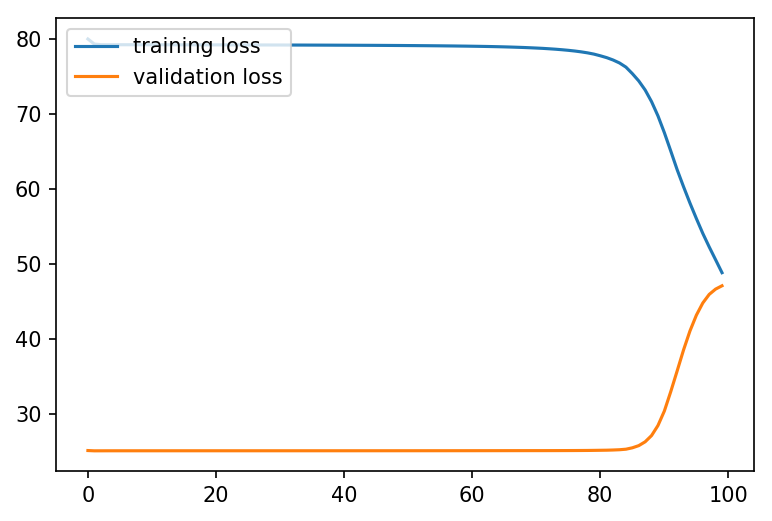

In [13]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

plt.figure()
plt.plot(tr_loss, label='training loss')
plt.plot(te_loss, label='validation loss')
plt.legend(loc='upper left')
plt.show()

### record

In [18]:
# samples = tr_input[0,:,:].numpy()
# for sample in samples:
# #     sample = sample[0,:]
# #     sample = samples[0,0,:]
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
#     ax1.plot(sample)
#     ax2.plot(abs(np.fft.fft(sample)))
#     plt.show()

#     N = 10
#     sample_filtered = np.convolve(sample, np.ones((N,))/N, mode='valid')

#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
#     ax1.plot(sample_filtered)
#     ax2.plot(abs(np.fft.fft(sample_filtered)))
#     plt.show()

In [19]:
# # size of moving average filter
# N = 10 
# # downsampling
# Nd = 5
# sample = lowpass_filtering(tr_input[0,0,:].numpy(), N)[::Nd]

# tr_input_filtered = torch.zeros([tr_input.shape[0],tr_input.shape[1],sample.shape[0]])
# te_input_filtered = torch.zeros([te_input.shape[0],te_input.shape[1],sample.shape[0]])

# for idx1, data in enumerate(tr_input):
#     for idx2, channel in enumerate(data):
#         tr_input_filtered[idx1, idx2, :] = torch.from_numpy(lowpass_filtering(channel.numpy(), 10)[::Nd])

# for idx1, data in enumerate(te_input):
#     for idx2, channel in enumerate(data):
#         te_input_filtered[idx1, idx2, :] = torch.from_numpy(lowpass_filtering(channel.numpy(), 10)[::Nd])
# tr_input = tr_input_filtered
# te_input = te_input_filtered

In [20]:
# sample = dc_blocker(tr_input[0,0,:].numpy())

# tr_input_filtered = torch.zeros([tr_input.shape[0],tr_input.shape[1],sample.shape[0]])
# te_input_filtered = torch.zeros([te_input.shape[0],te_input.shape[1],sample.shape[0]])

# for idx1, data in enumerate(tr_input):
#     for idx2, channel in enumerate(data):
#         tr_input_filtered[idx1, idx2, :] = torch.from_numpy(dc_blocker(channel.numpy()))

# for idx1, data in enumerate(te_input):
#     for idx2, channel in enumerate(data):
#         te_input_filtered[idx1, idx2, :] = torch.from_numpy(dc_blocker(channel.numpy()))


# tr_input = tr_input_filtered
# te_input = te_input_filtered

# sample = tr_input[1,6,:].numpy()
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
# ax1.plot(sample)
# sample_dc = dc_blocker(sample)
# ax2.plot(sample_dc)
# plt.show()

In [21]:
# sample = tr_input[:,11,:].numpy()
# for channel in sample[0:4]:
# #     plt.plot(channel)
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
# #     ax1.plot(channel)
#     sample_fft = np.fft.fft(channel)
# #     ax1.plot(abs(sample_fft))
#     ax1.plot(channel)
# #     ax2.plot(np.angle(sample_fft))
#     ax2.plot(abs(np.fft.fft(channel)))

#     plt.show()

In [22]:
# def fft_data(signal, size = 20):
#     sample_fft = np.fft.fft(signal)
#     sample_angle = np.angle(sample_fft)
    
#     return np.append(abs(sample_fft)[0:size],sample_angle[0:size])


# sample = fft_data(tr_input[0,0,:].numpy())

# tr_input_filtered = torch.zeros([tr_input.shape[0],tr_input.shape[1],sample.shape[0]])
# te_input_filtered = torch.zeros([te_input.shape[0],te_input.shape[1],sample.shape[0]])

# for idx1, data in enumerate(tr_input):
#     for idx2, channel in enumerate(data):
#         tr_input_filtered[idx1, idx2, :] = torch.from_numpy(fft_data(channel.numpy()))

# for idx1, data in enumerate(te_input):
#     for idx2, channel in enumerate(data):
#         te_input_filtered[idx1, idx2, :] = torch.from_numpy(fft_data(channel.numpy()))


# tr_input = tr_input_filtered
# te_input = te_input_filtered
